## Reason for Not Using Collate Function

- **Memory Efficiency**: When working with dense embeddings, memory efficiency becomes crucial. Utilizing offsets by concatenating indices allows for effective memory usage, particularly with PyTorch's `embedding_bag`, which minimizes computational load by summing embeddings based on these offsets.
  
- **Handling Variable Lengths**: Dense embeddings can represent sequences of varying lengths (like sentences or documents). Instead of padding these sequences, offsets are employed to indicate where each sequence begins, facilitating concatenation of indices. This approach avoids padding and enhances computational performance.

- **Sparse Embeddings**: Sparse embeddings, such as one-hot vectors or TF-IDF representations, are typically managed independently for each sample. Therefore, the use of concatenation and offset tracking is less critical since each document can be processed individually without needing special handling for sequence lengths.

In [1]:
import sys
import os

In [2]:
!pip install torchinfo

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from torchinfo import summary
import joblib
from collections import Counter
from functools import partial
from pathlib import Path
import torch
import torch.nn as nn
import random
import numpy as np
from sklearn.metrics import confusion_matrix

In [7]:
# Load the dataset
data = joblib.load("/content/drive/MyDrive/NLP/df_multilabel_hw_cleaned.joblib")
data.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47427 entries, 0 to 47426
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  47427 non-null  object
 1   Tags          47427 non-null  object
 2   Tag_Number    47427 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [9]:
import numpy as np
import ast

def process_data(data):
    def safe_convert_tag(tag):
        try:
            return ast.literal_eval(tag)
        except (ValueError, SyntaxError):
            return None


    y = [safe_convert_tag(tag) for tag in data['Tag_Number']]
    x = np.array(data['cleaned_text'].astype(str)).reshape(-1, 1)

    return x, y


# Use the function to process your data
x, y = process_data(data)

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y = mlb.fit_transform(y)

print(type(y) , y.shape)
print(type(x) , x.shape)

<class 'numpy.ndarray'> (47427, 10)
<class 'numpy.ndarray'> (47427, 1)


In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test_valid, y_train, y_test_valid = train_test_split(x, y,test_size=0.4,random_state=42)

# Further split the testing set into validation and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid,y_test_valid,test_size=0.5,random_state=42,shuffle=False)

In [16]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install -U nltk -qq
    !pip install -U spacy -qq
    !python -m spacy download en_core_web_sm -qq

    basepath = '/content/drive/MyDrive/NLP'
    sys.path.append('/content/drive/MyDrive/NLP')
else:
    basepath = '/Users/anxiousviking/Documents/course/Sem 3/NLP'
    sys.path.append(
    '/Users/anxiousviking/Documents/course/Sem 3/NLP/custom files')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [17]:
import CustomPreprocessorSpacy as cp

In [18]:
import spacy
nlp = spacy.load('en_core_web_sm')
cpp = cp.SpacyPreprocessor(model = 'en_core_web_sm', batch_size=1000)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+",max_features=5000)
vectorizer.fit(cpp.transform([str(x) for x in X_train.tolist()]))

/content/drive/MyDrive/NLP/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/usr/lib/python3.10/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


TfidfVectorizer(max_features=5000, token_pattern='[\\S]+')

In [20]:
from scipy.sparse import csr_matrix
class CustomDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for loading text and labels.

    Attributes:
        X (numpy.ndarray): Feature data, an array of texts.
        y (list or array-like): Target labels.
        vectorizer (TfidfVectorizer): The TF-IDF vectorizer used to transform the texts.
    """

    def __init__(self, X, y, vectorizer,cpp):
        """
        Initialize the dataset with feature and target data.

        Args:
            X (list or array-like): The feature data (texts).
            y (list or array-like): The target labels.
            vectorizer (TfidfVectorizer): The TF-IDF vectorizer used to transform the texts.
        """
        X = [str(x) for x in X.tolist()]

        # Storing feature data (texts)
        self.X = cpp.transform(X)

        # Storing the target labels
        self.y = y

        # Storing the TF-IDF vectorizer
        self.vectorizer = vectorizer

        # Transforming the texts to TF-IDF vectors
        self.X_tfidf = self.vectorizer.transform(self.X)

    def __len__(self):
        """
        Return the number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Fetch and return a single sample from the dataset at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            tuple: A tuple containing the label and the TF-IDF vector for the sample.
        """
        # Retrieve the TF-IDF vector and corresponding label from the dataset using the index
        tfidf_vector = csr_matrix.toarray(self.X_tfidf[idx])
        label = self.y[idx]

        # Convert label to tensor of type float
        label = torch.tensor(label, dtype=torch.float)

        # Convert TF-IDF vector to tensor
        tfidf_vector = torch.tensor(tfidf_vector, dtype=torch.float)

        # Packing them into a tuple before returning

        return tfidf_vector, label

In [21]:
# Create an instance of the CustomDataset class for the training set
trainset = CustomDataset(X_train, y_train,vectorizer,cpp)

# Create an instance of the CustomDataset class for the validation set
validset = CustomDataset(X_valid, y_valid,vectorizer,cpp)

# Create an instance of the CustomDataset class for the test set
testset = CustomDataset(X_test, y_test,vectorizer,cpp)

In [22]:
batch_size = 2
check_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           )

In [23]:
class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, output_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=drop_prob1)
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=drop_prob2)
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)
        self.output = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.hidden2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x = self.output(x)
        return x

In [24]:
INPUT_DIM=5000
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS = 10
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.000
CLIP_VALUE = 10
PATIENCE = 5
dropout_p = 0.3

In [25]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

model = CustomModel(input_dim=INPUT_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=0.5,
                       drop_prob2=0.5,
                       output_dim=NUM_OUTPUTS)

In [26]:
summary(model,(1, 5000))

Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [1, 10]                   --
├─Linear: 1-1                            [1, 200]                  1,000,200
├─ReLU: 1-2                              [1, 200]                  --
├─Dropout: 1-3                           [1, 200]                  --
├─BatchNorm1d: 1-4                       [1, 200]                  400
├─Linear: 1-5                            [1, 100]                  20,100
├─ReLU: 1-6                              [1, 100]                  --
├─Dropout: 1-7                           [1, 100]                  --
├─BatchNorm1d: 1-8                       [1, 100]                  200
├─Linear: 1-9                            [1, 10]                   1,010
Total params: 1,021,910
Trainable params: 1,021,910
Non-trainable params: 0
Total mult-adds (M): 1.02
Input size (MB): 0.02
Forward/backward pass size (MB): 0.00
Params size (MB): 4.09
Estimated Total Size (MB

In [27]:
# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model = model.to(device)

# Generate some dummy input data and offsets, and move them to the device
data = trainset[0][0].squeeze(1).to(device)

In [28]:
# Switch the model to evaluation mode
model.eval()

# Perform inference
output = model(data)

print(output)

tensor([[ 0.0666,  0.0379,  0.0703, -0.0464,  0.0093,  0.0948, -0.0247, -0.0623,
         -0.0508, -0.0895]], grad_fn=<AddmmBackward0>)


In [31]:
!pip install torchmetrics
from torchmetrics import HammingDistance

def step(inputs, targets, model, device, loss_function=None, optimizer=None,clip_type='value',clip_value=10.0):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - train_hamming_distance (torchmetrics.HammingDistance): The Hamming distance metric.
    """
    # Move the model and data to the device
    model = model.to(device)
    inputs, targets = inputs.squeeze(1).to(device), targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Update Hamming Distance metric
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    y_pred = (outputs > 0.5).float()
    train_hamming_distance.update(y_pred, targets)

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        if clip_type == 'value':
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, train_hamming_distance
    else:
        return outputs, train_hamming_distance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 16.4 MB/s eta 0:00:00


In [32]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    """
    Trains the model for one epoch using the provided data loader and updates the model parameters.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader object for the training set.
    - model (torch.nn.Module): The neural network model to be trained.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to use for training.
    - optimizer (torch.optim.Optimizer): The optimizer to update model parameters.

    Returns:
    - train_loss (float): Average training loss for the epoch.
    - epoch_hamming_distance (float): Hamming distance for the epoch.
    """
    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    running_train_correct = 0

    # Initialize Hamming Distance metric
    hamming = HammingDistance(task="multilabel", num_labels=10).to(device)

    # Iterate over all batches in the training data
    for inputs, targets in train_loader:
        # Move data to the appropriate device
        inputs, targets = inputs.squeeze(1).to(device), targets.to(device)

        # Perform a forward and backward pass, updating model parameters
        loss, _, _ = step(inputs, targets, model, device, loss_function, optimizer)

        # Update running loss
        running_train_loss += loss.item()

        # Compute Hamming Distance for the epoch
        y_pred = (model(inputs) > 0.5).float()
        hamming.update(y_pred, targets)

    # Compute average loss for the entire training set
    train_loss = running_train_loss / len(train_loader)

    # Compute Hamming Distance for the epoch
    epoch_hamming_distance = hamming.compute()

    return train_loss, epoch_hamming_distance

In [33]:
from torchmetrics import HammingDistance

def val_epoch(valid_loader, model, device, loss_function):
    """
    Validates the model for one epoch using the provided data loader.

    Parameters:
    - valid_loader (torch.utils.data.DataLoader): DataLoader object for the validation set.
    - model (torch.nn.Module): The neural network model to be validated.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module): The loss function to evaluate the model.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - val_hamming_distance (float): Hamming distance for the epoch.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and Hamming Distance
    running_val_loss = 0.0
    val_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)

    # Disable gradient computation
    with torch.no_grad():
        # Iterate over all batches in the validation data
        for inputs, targets in valid_loader:
            # Move data to the appropriate device
            inputs, targets = inputs.squeeze(1).to(device), targets.to(device)

            # Perform a forward pass to get loss and number of correct predictions
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

            # Update running loss
            running_val_loss += loss.item()

            # Update Hamming Distance metric
            val_hamming_distance.update(torch.round(torch.sigmoid(outputs)), targets)

    # Compute average loss and Hamming Distance for the entire validation set
    val_loss = running_val_loss / len(valid_loader)
    val_hamming_distance = val_hamming_distance.compute()

    return val_loss, val_hamming_distance


In [34]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience=5):
    """
    Trains and validates the model, and returns history of train and validation metrics.

    Parameters:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - model (torch.nn.Module): Neural network model to train.
    - optimizer (torch.optim.Optimizer): Optimizer algorithm.
    - loss_function (torch.nn.Module): Loss function to evaluate the model.
    - epochs (int): Number of epochs to train the model.
    - device (torch.device): The computing device (CPU or GPU).
    - patience (int): Number of epochs to wait for improvement before early stopping.

    Returns:
    - train_loss_history (list): History of training loss for each epoch.
    - train_hamm_history (list): History of training Hamming distance for each epoch.
    - valid_loss_history (list): History of validation loss for each epoch.
    - valid_hamm_history (list): History of validation Hamming distance for each epoch.
    """

    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []
    train_hamm_history = []
    valid_hamm_history = []

    # Initialize variables for early stopping
    best_valid_loss = float('inf')
    no_improvement = 0

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_hamm = train_epoch(
            train_loader, model, device, loss_function, optimizer)

        # Validate model on validation data and capture metrics
        valid_loss, valid_hamm = val_epoch(
            valid_loader, model, device, loss_function)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_hamm_history.append(train_hamm)
        valid_hamm_history.append(valid_hamm)

        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_hamm:.4f}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Hamming Distance: {valid_hamm:.4f}")
        print()

        # Check for early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement == patience:
                print(f"No improvement for {patience} epochs. Early stopping...")
                break

    return train_loss_history, train_hamm_history, valid_loss_history, valid_hamm_history


In [35]:
# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.0
PATIENCE=10

In [36]:
# Fixing the seed value for reproducibility across runs
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


# Define the device for model training (use CUDA if available, else CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data Loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Define the loss function for the model, using cross-entropy loss
loss_function = nn.BCEWithLogitsLoss()

# Define the model with specified hyperparameters
model = CustomModel(input_dim=INPUT_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=0.5,
                       drop_prob2=0.5,
                       output_dim=NUM_OUTPUTS)

model = model.to(device)

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [37]:
for inputs, targets in train_loader:
  print(type(inputs))
  print(inputs.shape)
  print(targets.shape)
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<class 'torch.Tensor'>
torch.Size([128, 1, 5000])
torch.Size([128, 10])


In [38]:
for inputs, targets in train_loader:
    # Move inputs and targets to the CPU.
    inputs = inputs.squeeze(1).to(device)
    targets = targets.to(device)
    model = model.to(device)
    model.eval()
    # Forward pass
    with torch.no_grad():
        output = model(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.6789126396179199
Expected Theoretical loss: 0.6931471805599453


In [39]:
CLIP_VALUE = 10
# Call the train function to train the model
train_losses, train_hamm, valid_losses, valid_hamm = train(
    train_loader, valid_loader, model, optimizer, loss_function, EPOCHS, device, patience=PATIENCE
)

Epoch 1/5
Train Loss: 0.3474 | Train Hamming Distance: 0.0855
Valid Loss: 0.1411 | Valid Hamming Distance: 0.0491

Epoch 2/5
Train Loss: 0.1348 | Train Hamming Distance: 0.0474
Valid Loss: 0.1161 | Valid Hamming Distance: 0.0437

Epoch 3/5
Train Loss: 0.1074 | Train Hamming Distance: 0.0391
Valid Loss: 0.1085 | Valid Hamming Distance: 0.0392

Epoch 4/5
Train Loss: 0.0920 | Train Hamming Distance: 0.0330
Valid Loss: 0.1041 | Valid Hamming Distance: 0.0372

Epoch 5/5
Train Loss: 0.0827 | Train Hamming Distance: 0.0303
Valid Loss: 0.1045 | Valid Hamming Distance: 0.0372



In [40]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    """
    Plot training and validation loss and metrics over epochs.

    Args:
        train_losses (list): List of training losses for each epoch.
        train_metrics (list): List of training metrics (e.g., accuracy) for each epoch.
        val_losses (list, optional): List of validation losses for each epoch.
        val_metrics (list, optional): List of validation metrics for each epoch.

    Returns:
        None
    """
    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if val_losses:  # Check if validation losses are provided
        plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")
        if val_metrics:
            plt.plot(epochs, val_metrics, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()


In [41]:
train_hamm

[tensor(0.0855),
 tensor(0.0474),
 tensor(0.0391),
 tensor(0.0330),
 tensor(0.0303)]

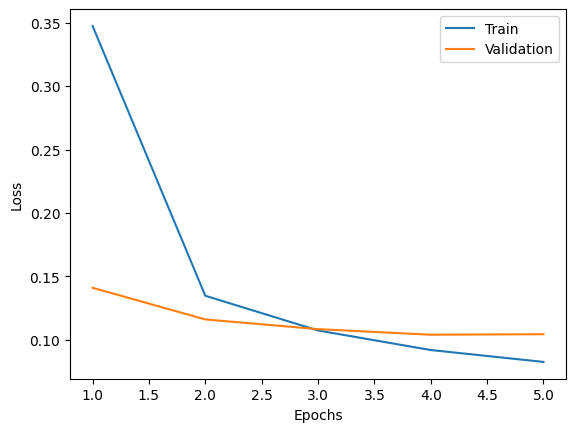

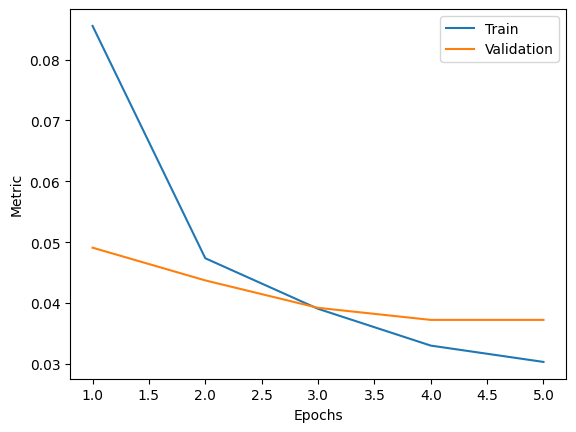

In [42]:
import numpy as np
# Plot the training and validation losses and metrics
train_hamm_np = [ham.cpu().numpy() for ham in train_hamm]
valid_hamm_np = [ham.cpu().numpy() for ham in valid_hamm]
plot_history(train_losses, train_hamm_np, valid_losses, valid_hamm_np)

In [43]:
def get_acc_pred(data_loader, model, device):
    """
    Function to get predictions and accuracy for a given data using a trained model
    Input: data iterator, model, device
    Output: predictions and accuracy for the given dataset
    """
    model = model.to(device)
    # Set model to evaluation mode
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data iterator
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Process the batch to get the loss, outputs, and correct predictions
            outputs, _ = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            # Choose the label with maximum probability
            # Correct prediction using thresholding
            y_pred = (outputs.data>0.5).float()

            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, y_pred))
            y = torch.cat((y, targets.to(device)))

    # Calculate accuracy by comparing the predicted and actual labels
    accuracy = (predictions == y).float().mean()

    # Return tuple containing predictions and accuracy
    return predictions, accuracy, y

In [44]:
# Get the prediction and accuracy
predictions_test, acc_test, y_test = get_acc_pred(test_loader, model, device)
predictions_train, acc_train, y_train = get_acc_pred(train_loader, model, device)
predictions_valid, acc_valid, y_valid = get_acc_pred(valid_loader, model, device)

In [45]:
# Print Test Accuracy
print('Valid accuracy', acc_valid * 100)

Valid accuracy tensor(96.1191)


In [46]:
from sklearn.metrics import multilabel_confusion_matrix

def plot_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots a confusion matrix.

    Args:
        valid_labels (array-like): True labels of the validation data.
        valid_preds (array-like): Predicted labels of the validation data.
        class_labels (list): List of class names for the labels.
    """
    # Compute the confusion matrix
    cm = multilabel_confusion_matrix(valid_labels, valid_preds)

    # Plot the confusion matrix using Seaborn
    fig, axs = plt.subplots(1, len(class_labels), figsize=(15, 5))
    for i, (label, matrix) in enumerate(zip(class_labels, cm)):
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Reds", xticklabels=['0', '1'], yticklabels=['0', '1'], ax=axs[i])
        axs[i].set_title(f"Confusion Matrix for Class {label}")
        axs[i].set_xlabel('Predicted Labels')
        axs[i].set_ylabel('True Labels')

    # Display the plot
    plt.tight_layout()
    plt.show()

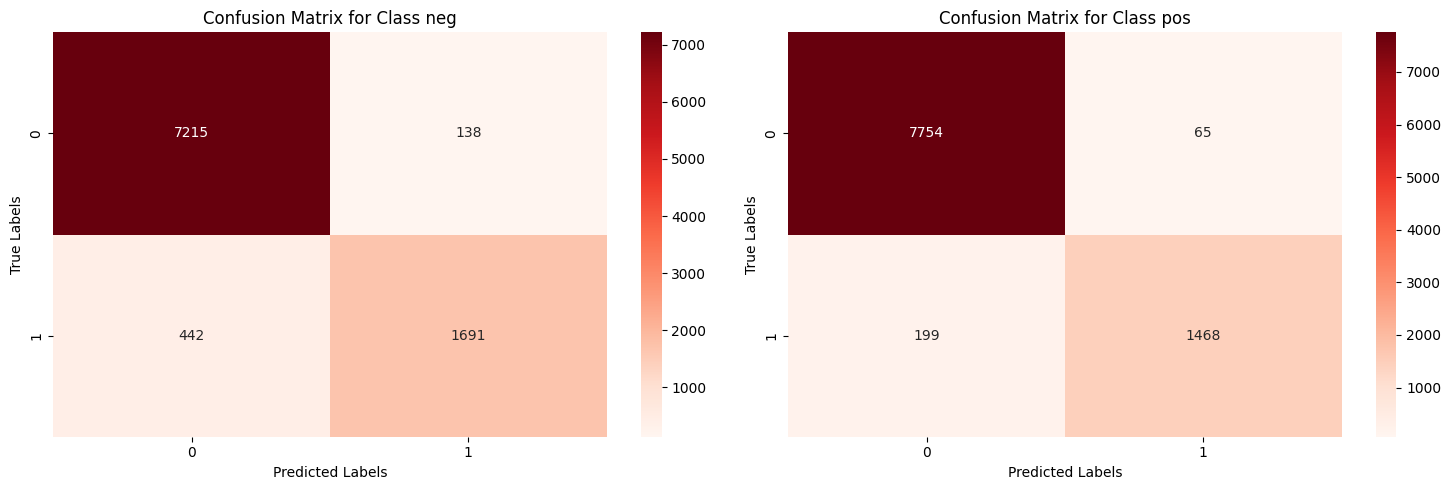

In [47]:
plot_confusion_matrix(y_test.cpu().numpy(), predictions_test.cpu().numpy(), class_labels=['neg', 'pos'])

In [48]:
test_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
test_hamming_distance.update(y_test, predictions_test)

In [49]:
test_hamming_distance.compute()

tensor(0.0379)

## Inferences

**Confusion Matrix**:
- **Negative Class**: True negatives are high at 7,215, indicating the model effectively predicts negative labels. However, there are 442 false negatives, showing instances where the model incorrectly predicts a sample as negative.
- **Positive Class**: True positives are also significant at 1,468, reflecting the model's strong performance in predicting positive labels. It has a low false positive rate of 65 and a moderate 199 false negatives, suggesting better performance on the positive class compared to the negative.

**Curves**:
- **Train Loss**: There is clear evidence of learning, with a steady decline in training loss. A sharp drop between epochs 1 and 2 indicates quick adaptation to the training data.
- **Validation Loss**: This loss decreases and plateaus around epoch 3, suggesting the model is nearing its generalization limit. The small gap between training and validation loss indicates good generalization without overfitting.
- **Stable Validation Loss**: The relatively flat curve after epoch 3 suggests that further training may not significantly enhance performance on the validation set.
- **Train Metric**: The model shows improved performance on the training data, correlating with the loss curve's significant drop between epochs 1 and 2.
- **Validation Metric**: This metric mirrors the training trend, decreasing sharply in early epochs and flattening around epoch 3, indicating strong performance on unseen data, although improvements may slow after this point.
- **Generalization**: As the validation metric flattens while the training metric continues to drop slightly, the model shows minimal overfitting, indicating potential benefits from early stopping after epochs 3 or 4.